In [1]:
# -*- coding: utf-8 -*-
import requests
import time
import json

In [2]:
# https://pypi.org/project/jiwer/
#!pip install jiwer

In [2]:
#!pip install gapic-google-cloud-speech-v1beta1

In [3]:
import os
import wave
from vosk import Model, KaldiRecognizer, SetLogLevel
import jiwer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#!pip install --upgrade google-cloud-speech

In [5]:
import io
import os
from google.cloud import speech_v1p1beta1

In [6]:
def transcribe_vosk(file_name):

    # https://alphacephei.com/vosk/
    
    model_path = '/home/alex/projects/vosk-api/python/example/vosk-model-ru-0.10'
    phrases_list = []

    # read file
    wf = wave.open(file_name, "rb")

    # read model
    model = Model(model_path)
    rec = KaldiRecognizer(model, wf.getframerate())

    # recognizing
    while True:

        conf_score = []

        data = wf.readframes(4000)
        if len(data) == 0:
            break

        if rec.AcceptWaveform(data):
            accept = json.loads(rec.Result())
            if accept['text'] !='':

                accept_start	= str(accept['result'][0]['start'])
                accept_end   	= accept['result'][-1:][0]['end']
                accept_text		= str(accept['text'])

                for result_rec in accept['result']:
                    conf_score.append(float(result_rec['conf']))
                conf_mid = str(sum(conf_score)/len(conf_score))
                conf_score = []
                
                phrases_list.append(accept_text)
    return phrases_list

In [7]:
def transcribe_sova(file_name):
    
    # https://habr.com/ru/company/ashmanov_net/blog/523412/
    # https://github.com/sovaai/sova-asr
    
    url = "http://localhost:8888/asr/"
    f1 = open(file_name, 'rb')
    response = requests.post(url,files={"audio_blob": f1}).text
    return json.loads(response)['r'][0]['response'][0]['text']    

In [8]:
def transcribe_google(file_path):
    
    # https://cloud.google.com/speech-to-text
    # https://cloud.google.com/speech-to-text/docs/reference/rest/v1/RecognitionConfig?hl=ru#AudioEncoding
    
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'google_app_cred.json'    
    language = 'ru'
    client = speech_v1p1beta1.SpeechClient()    
    sample_rate_hertz = 8000
    encoding = speech_v1p1beta1.RecognitionConfig.AudioEncoding.MP3

    config = {
        "language_code": language,
        "sample_rate_hertz": sample_rate_hertz,
        "encoding": encoding,
    }
    with io.open(file_path, 'rb') as audio_file:
        content = audio_file.read()
        audio = speech_v1p1beta1.RecognitionAudio(content=content)

        response = client.recognize(config = config, audio = audio)
        results = []
        for result in response.results:
            alternative = result.alternatives[0]
            results.append(alternative.transcript)
    return ''.join([str(item) for item in results]).lower()

In [9]:
def transcribe_yandex(filelink):
    
    # https://cloud.yandex.ru/services/speechkit

    # Укажите ваш API-ключ и ссылку на аудиофайл в Object Storage.
    with open('yandex_api.key', 'r') as file:
        key = file.read().replace('\n', '')
        file.close()

    POST = "https://transcribe.api.cloud.yandex.net/speech/stt/v2/longRunningRecognize"

    body ={
        "config": {
            "specification": {
                "languageCode": "ru-RU"
            }
        },
        "audio": {
            "uri": filelink
        }
    }

    # Если вы хотите использовать IAM-токен для аутентификации, замените Api-Key на Bearer.
    header = {'Authorization': 'Api-Key {}'.format(key)}

    # Отправить запрос на распознавание.
    req = requests.post(POST, headers=header, json=body)
    data = req.json()

    id = data['id']

    # Запрашивать на сервере статус операции, пока распознавание не будет завершено.
    while True:

        time.sleep(1)

        GET = "https://operation.api.cloud.yandex.net/operations/{id}"
        req = requests.get(GET.format(id=id), headers=header)
        req = req.json()

        if req['done']: break
        #print("Not ready")

    # Показать полный ответ сервера в формате JSON.
    #print("Response:")
    #print(json.dumps(req, ensure_ascii=False, indent=2))

    # Показать только текст из результатов распознавания.
    #print("Text chunks:")
    result = ''
    for chunk in req['response']['chunks']:
        result += chunk['alternatives'][0]['text'] + ' '

    return result.lower()

In [10]:
def error(ground_truth, hypothesis):
    
    wer = jiwer.wer(ground_truth, hypothesis)
    mer = jiwer.mer(ground_truth, hypothesis)
    wil = jiwer.wil(ground_truth, hypothesis)

    # faster, because `compute_measures` only needs to perform the heavy lifting once:
    measures = jiwer.compute_measures(ground_truth, hypothesis)
    return measures

In [11]:
def load_data(files):
    
    frames = [pd.read_csv(file) for file in files]
    return pd.concat(frames, ignore_index=True)

In [12]:
def dictonary_init_print(path, skip_init = False):
    if not skip_init:
        print("human = []")
    for root, dirs, files in os.walk(path):
        files.sort()
        for filename in files:
            print("human.append({'path': '" + path + "', 'file': '" + filename + "', 'human_text': ''})")

In [13]:
def evaluate(name):
    
    wer = []
    mer = []
    wil = []
    for row in range(len(df)):
        measures = error(df.iloc[row].human_text, df.iloc[row][name + '_text'])
        wer.append(measures['wer'])
        mer.append(measures['mer'])
        wil.append(measures['wil'])
    df[name + '_wer'] = wer
    df[name + '_mer'] = mer
    df[name + '_wil'] = wil

In [14]:
def plot(names):
    
    errors = ['wer', 'mer', 'wil']
    for r in errors:
        df.plot(y = [n + '_' + r for n in names], kind='bar')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        plt.grid(linestyle='--', alpha=0.5)
        plt.show()

In [15]:
def comparator(engines, evals):
    
    comparing = []
    for g in engines:
        for v in evals:
            comparing.append({
                'engine': g,
                'eval_func': v,
                'val': np.median(df[g + '_' + v])
            })
    comp_df = pd.DataFrame(comparing)
    for v in evals:
        data_pointer = comp_df[comp_df.eval_func == v]
        plt.plot(data_pointer.engine, data_pointer.val, label = v)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()

    for v in evals:
        print('\n' + v + ':')
        for g in engines:    
            print(g, np.median(df[g + '_' + v]))

In [16]:
def examples(engines, limit = 0):

    for i in range(min(len(df), len(df) if limit == 0 else limit)):

        print('\n=== example ' + str(i) + ' ===')

        for g in engines:
            print('\n' + g + ':')
            print(df.loc[i][g + '_text'])

### fill with human typed data

In [ ]:
# batch 0
dictonary_init_print(path = 'data')

In [ ]:
human = []
human.append({'path': 'data', 'file': 'lo1615965189.2255215-out.wav', 'human_text': 'слушаю вас ага вы знаете что я вчера вечером в одинадцать часов включила стиральную машину она бош натуральная немецкой сборки очень старая мах четыре ну и работала так быстро быстро быстро в одинадцать вечера и вот он вдруг погасло все выключилось и не включается света нету стиральная машина ну спасибо большое досвидания'})
human.append({'path': 'data', 'file': 'lo1615966037.2256002-out.wav', 'human_text': 'але да да ну надо ремонтировать там и это ну там комфорка плохо работает и надо еще метель смотреть да да да да ясно тогда ладно лучше я договорюсь хозяйку потому что угу хорошо ага спасибо'})
human.append({'path': 'data', 'file': 'lo1615967475.2257111-out.wav', 'human_text': 'алло да ну вроде бы жена постирала вроде бы жалоб небыло вроде бы отжала хорошо да спасибо'})
human.append({'path': 'data', 'file': 'lo1615967560.2257152-out.wav', 'human_text': 'да але а вы извините он у нас начал показывать спасибо большое за это за заботу что то там отдохнул маленько и показывать стал алё ага досвидания'})

In [ ]:
# batch 1
dictonary_init_print(path = 'low2', skip_init = True)

In [ ]:
human.append({'path': 'low2', 'file': '1615968462.2257561-in.wav', 'human_text': 'алло здравствуйте это я сейчас не к вам звонил случайно алло аздрастье меня зовут иван мастер по стиральным машинам скажите пожалуйста если подъеду где то с часу до четырех дома будете хорошо тогда предварительно через пять минут вам наберем постараться можно будет но обычно с десяти до двенадцати в таком промежутке все давайте я да заранее позвоню да все давайте на пятницу тогда давайте'})
human.append({'path': 'low2', 'file': '1615968751.2257736-in.wav', 'human_text': 'алло здравсвуйте алло да здрасьте это роман по ремонту стиральных машин мастер вы дома ну еду к вам тогда там когда будете ну все тогда я я понял ну я на автозаводе тоже выезжаю ну все тогда я еду к вам ага все до свидания'})
human.append({'path': 'low2', 'file': '1615974690.2261028-out.wav', 'human_text': 'отк ксения здравствуйте чеботовская семнадцать минутку але через час ну да все конечно нормально ждем вас ага угу до свидания'})
human.append({'path': 'low2', 'file': '1615979494.2263673-in.wav', 'human_text': 'але алло здравствуйте еще раз это мастер да я еще не закончил тут примерно помоему закончу примерно закончу около шести так семи может приеду к вам если успею да успею я щас могу и не успеть ну вот я стараюсь там может побыстрей ну ладно я вас буду ждать хорошо я позвоню еще ага хорошо хорошо ладно'})
human.append({'path': 'low2', 'file': '1615981935.2265552-out.wav', 'human_text': 'да слушаю ага так да да да двадцать восьмая квартира этот четвертый этаж да там один всего подъезд вы из лифта выходите и налево поворачиваете из лифта вниз по лестнице налево да двадцать восемь просто набрать и все хорошо спасибо до свидания'})
human.append({'path': 'low2', 'file': '1615982614.2265863-out.wav', 'human_text': 'але да да это двадцать второго было да это начинать да да пять пятницу буду я девятнадцатого да да да да да послезавтра да да знаю до встречи'})
human.append({'path': 'low2', 'file': '1615987721.2268171-in.wav', 'human_text': 'да да это мастер слушайте у меня такая просьба а если давайте завтра может часикам к одинадцати нормально будет с одинадцати до двенадцати да а то у меня не успели запчасти ну сальник привезти а привезут его после шести а там работы часа на полтора два ну уже просто поздновато будет все да часикам к одинадцати завтра меня ждите тогда да да да все записываю единственное что я сразу вам скажу там если будет че то какая нибудь там простыночка старая что нибудь такого найдите пожалуйста ладно да все понял все сегодня все возьму запчасти все завтра все сделаем ага все завтра тогда спасибо'})
human.append({'path': 'low2', 'file': '1616046849.2275204-in.wav', 'human_text': 'доброе утро это телемастер заявочку оставляли вы хотели на исадченко он у вас был да когда то приставку угу я ему передам он вам перезвонит будьте на связи ну решите ну с ним пообщаетесь угу до свидания пожалуйста'})
human.append({'path': 'low2', 'file': '1616047338.2275327-out.wav', 'human_text': 'але ага здрасьте да все все нормально не надо уже да да да все все нормально не знаю так вы можете сказать что клиент отказался ну давайте ладно наберу все давайте да давайте да вот на этот номер набрать да давайте все давайте до свидания'})
human.append({'path': 'low2', 'file': '1616051676.2277358-in.wav', 'human_text': 'але добрый христин сто пятьдесят пять тридцать один девяносто шесть сто пятьдесят пять тридцать один девяносто шесть да щас че обратил внимание там пометка стоит сообщение клиент просит перезвонить там перезванивал общались ага ага понятно ну тогда позвоните спросите что хотели угу'})
human.append({'path': 'low2', 'file': '1616053311.2278833-out.wav', 'human_text': 'але на два стекло бесплатно девушка это раз два всегда ну он хочет пятнадцать тысяч за диагностику прикалываетесь что ли девушка не девушка диагностика бесплатно я с вами разговаривал он выехал посмотрел и посмотрел что вы прикалываетесь девушка он там даже ничего не сделал он там посмотрел две с половиной тысячи вам буду отдавать пускай делает обратно он ничего не сделал я не готов я не готов ничего не оплатить девушка он посмотрел и ничего не сделал я никуда не поеду девушка до свидания'})
human.append({'path': 'low2', 'file': '1616062036.2283558-out.wav', 'human_text': 'отк евгения все вышки ожидайте да дома ждут вас пожалуйста'})
human.append({'path': 'low2', 'file': '1616065078.2284974-out.wav', 'human_text': 'отк татьяна здравствуйте угу угу на этаже у парадной угу минутку алексей юрьевич он едет будет в течении пятнадцати минут подождете угу все тогда угу'})
human.append({'path': 'low2', 'file': '1616066615.2285968-in.wav', 'human_text': 'японская фирма ширихари я знаю жена покупает постоянно такенный балон да ну что там делаешь что делаешь пойдешь не звонила ребятам там нет ну ладно устала нормально ладно давай тогда шуруй родителям не звонила что то там опять эти горчишник ставят тридцать сем температура блин угу набери спроси что он там слышь все ладно тогда пришли что нибудь там дениска фотографировать видео давай пока'})
human.append({'path': 'low2', 'file': '1616066615.2285968-out.wav', 'human_text': 'але да дома ну ща пойду уже угу да нет да нет нормально угу давай да нет не звонит господи о понятно угу ладно давай пока'})
human.append({'path': 'low2', 'file': '1616070696.2288408-out.wav', 'human_text': 'алло привет я у тебя хотела спросить этот самый ты когда можешь или сегодня или завтра вы ой хотела ну ненадолго зайти нет ни я могу зайти ага ну ладно ага ну потихонечку ну вот он как скажем ну все ага не ну я сегодня хотела до храма тоже дойти хот это я еще не была а тогда тут тогда к тебе заскочу ладно все а ладно все а угу да'})
human.append({'path': 'low2', 'file': '1616073178.2289438-in.wav', 'human_text': 'алло это мастер в общем к пяти я подъезжаю да к вам а даже можно пораньше подъехать будет а а все тогда ждите скоро буду ага ну диагностика тысяча четыреста а да работа ага не ничего не нужно ага все все ждите'})
human.append({'path': 'low2', 'file': '1616074025.2289882-out.wav', 'human_text': 'да угу а квартира восьем ой дом восемь квартира восемнадцать первый подъезд пятый этаж домофон шестьдесят три восемьдесят шесть да или позвоните там у меня домофон дома это вы прийдете уже делать угу хорошо жду вас угу'})
human.append({'path': 'low2', 'file': '1616084945.2294168-in.wav', 'human_text': 'алло еще раз здравствуйте это мастер я про вас не забыл еду к вам минут где то в течении тридцати буду у вас у вас подъезд какой будет в течении тридцати минут угу тридцать подъезд у вас какой будет подъезд подъезд какой будет хорошо все позвоню вам подъеду'})
human.append({'path': 'low2', 'file': '1616143839.2301898-in.wav', 'human_text': 'алло здрасьте это насчет холодильника александр беспокоит вы как дома вообще находитесь ага ну я к вам подъеду тогда конаковский проезд дом двенадцать корпус два квартира напомните э подъезд этаж код домофона как пройти да это на площадке который находится на лестнице хорошо ну он сейчас выключен да мы с вами договаривались холодильник включен да мы с вами договаривались ага ну давайте сейчас я быстренько подъеду к вам ага'})
human.append({'path': 'low2', 'file': '1616143955.2301955-in.wav', 'human_text': 'але добрый день да сервисный центр мастер беспокоит по поводу холодильника да индезит да а морозильник да не морозит да я понял вы дома дома так семашко семнадцать корпус один квартира какая будет шестьдесят три подъезд этаж угу этаж четвертый скажите он сейчас включенный работает или выключенный ну включите его в розетку пускай начнет работать в любом состоянии я сейчас подъеду посмотрим давайте да'})
human.append({'path': 'low2', 'file': '1616152551.2306419-in.wav', 'human_text': 'але это мастер здравствуйте еще раз подскажите подъезд этаж и номер квартиры двадцать пять этаж я я еще не подъехал я только еду угу угу хорошо а подъезд номер все хорошо хорошо через пол часа я буду у вас'})

In [ ]:
df = pd.DataFrame().from_dict(human)

### tts

In [ ]:
# vosk
transcribations = []
for path, file in df[['path', 'file']].values:
    vosk_phrases = transcribe_vosk(path + '/' + file)            
    transcribations.append(' '.join([str(item) for item in vosk_phrases]))
df['vosk_text'] = transcribations

In [ ]:
# sova
transcribations = []
for path, file in df[['path', 'file']].values:
    transcribations.append(transcribe_sova(path + '/' + file))
df['sova_text'] = transcribations

In [ ]:
# google
transcribations = []
for path, file in df[['path', 'file']].values:
    transcribations.append(transcribe_google(path + '/' + file))
df['google_text'] = transcribations

In [ ]:
# yandex
# conver to ogg
for path, file in df[['path', 'file']].values:
    
    os_cmd 	= 'ffmpeg -i '
    os_cmd += path + '/' + file
    os_cmd += ' -acodec libopus'
    os_cmd += ' temp/' + file + '.ogg'
    try:
        os.system(os_cmd)
    except Exception as e:
        print('ffmpeg converting error:',str(e))
print("now drag'n'drop files to bucket")

In [ ]:
transcribations = []
for path, file in df[['path', 'file']].values:
    transcribations.append(transcribe_yandex('https://storage.yandexcloud.net/format37audio/' + file + '.ogg'))
df['yandex_text'] = transcribations

### eval

In [ ]:
evaluate('vosk')
evaluate('sova')
evaluate('google')
evaluate('yandex')

### load data

In [18]:
df = load_data(['data_full.csv'])

### save data

In [ ]:
df.to_csv('data_full.csv', index=False)

### plot

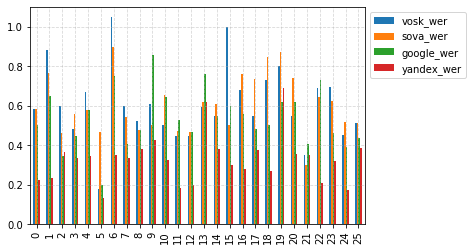

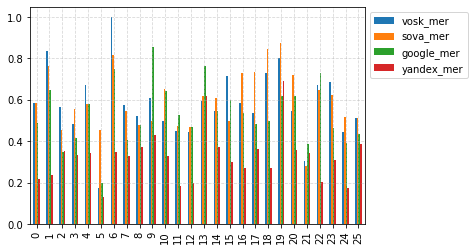

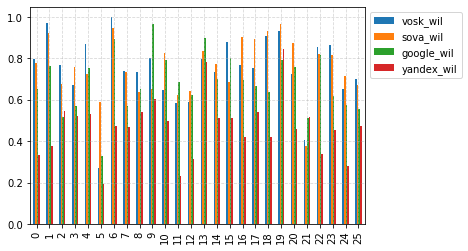

In [18]:
plot(['vosk', 'sova', 'google', 'yandex'])

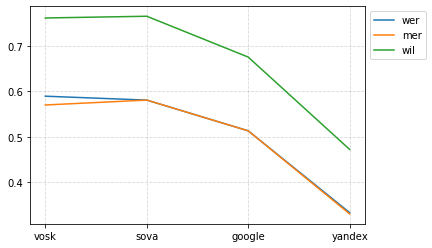


wer:
vosk 0.5892857142857143
sova 0.5807291666666667
google 0.513157894736842
yandex 0.3333333333333333

mer:
vosk 0.5699537750385208
sova 0.5807291666666667
google 0.513157894736842
yandex 0.33045977011494254

wil:
vosk 0.7612601214574899
sova 0.7650660742766006
google 0.6752854102167183
yandex 0.4722012362637362


In [19]:
comparator(
    engines = ['vosk', 'sova', 'google', 'yandex'],
    evals = ['wer', 'mer', 'wil']
)

### Word Error Rate
The present de facto standard index for ASR system assessment is the Word Error Rate, which is defined as the proportion of word errors to
words processed
### Match error rate
Probability of a given match being incorrect
### Word information lost
Simple function of HSDI counts by making use of an equation linking mutual information with Pearson's Large Sample Statistic, and then retaining only dominant terms.

### Conclusion
MER and WIL both provide simple CSR performance measures which vary from 0 when there are no errors to 1 when
there are no hits. They are more suitable than WER for the evaluation of any application in which the proportion of word information communicated is more meaningful than edit cost.   
At low error rates all three give similar scores so that the inappropriate theoretical basis for the WER measure is not noticeable. However, in tests for many real world applications, where significant error rates are common and choosing the best system is very important, the rankings given by each measure start to differ significantly and the risk of incorrect choice of best performing system becomes very real. Statistical tests used with WER can also be applied to MER and WIL. Both MER and WIL have intuitively simple probabilistic interpretations, but in so far as WIL measures the proportion of (mapping sensitive) word information communicated (at least, when N is dominated by H), and communication is mainly what speech is for, it is the preferred measure.
   
<a href="https://www.researchgate.net/publication/221478089_From_WER_and_RIL_to_MER_and_WIL_improved_evaluation_measures_for_connected_speech_recognition">From_WER_and_RIL_to_MER_and_WIL_improved_evaluatio.pdf</a>


In [19]:
examples(['human', 'vosk', 'sova', 'google', 'yandex'], 0)


=== example 0 ===

human:
але да да ну надо ремонтировать там и это ну там комфорка плохо работает и надо еще метель смотреть да да да да ясно тогда ладно лучше я договорюсь хозяйку потому что угу хорошо ага спасибо

vosk:
королев далее ну надо ремонтировать там я там комфорт и плохо работаете надо ещё вылить весьма блядь да да да да ясно тогда вам лучше я поговорю с хозяйкой что хорошо

sova:
алло да но надо ремонтировать там кретину там комфорт плохо работаете надо ещё уметь весьма ответить да да да да ясно тогда случая поговорить хозяйку что хорошо посе

google:
алло надо ну надо ремонтировать там ответил ну там комфорт плохо работает и надо ещё внутри смотреть да-да-да ясно тогда вас лучше я поговорю с хозяйку потому что хорошо

yandex:
алло да да ну надо ремонтировать там е ну там комфорт плохо работает и надо еще внутри смотреть ну да да да да ясно тогда лучше я поговорить хозяйку потому что угу хорошо ага спасибо 

=== example 1 ===

human:
алло да ну вроде бы жена постирала вр